In [1]:
import pandas as pd
import json

In [2]:
df = pd.DataFrame(columns=['Play','Act','Scene','Character','Line'])

In [3]:
data = None
with open('output/shakespeare_acts_scenes.json') as f:
    data = json.load(f)

In [4]:
for play_name,play_content in data.items():
    for acts,scenes in play_content.items():
        for scene,lines in scenes.items():
            for line in lines:
                if len(line)>1:
                    df = df.append({'Play':play_name, 'Act':acts, 'Scene':scene, 'Character':line[0].title(), 'Line':line[1]}, ignore_index=True)

In [5]:
df['Line_chars'] = df.apply(lambda x: len(x['Line']), axis=1)

In [6]:
df.drop(df[df['Line_chars']==1].index, inplace=True) # remove lines of only one char; only two such instances

In [7]:
import spacy
import en_core_web_lg

from spacy.tokenizer import Tokenizer

In [8]:
nlp = en_core_web_lg.load()
tokenizer = Tokenizer(nlp.vocab)

In [9]:
df['Line_spacy'] = df.apply(lambda x: (len(tokenizer(x['Line'])),tokenizer(x['Line'])), axis=1)
df[['Line_spacy_len','Line_spacy']] = df['Line_spacy'].to_list()

/home/bryan/Documents/Code/python-environments/SHAKESPEAREAN_NETWORKS/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
df.head()

,Play,Act,Scene,Character,Line,Line_chars,Line_spacy,Line_spacy_len
0,romeo,ACT I,SCENE I,Sampson,"Gregory, on my word, we’ll not carry coals.",43,"(Gregory,, on, my, word,, we’ll, not, carry, c...",8
1,romeo,ACT I,SCENE I,Gregory,"No, for then we should be colliers.",35,"(No,, for, then, we, should, be, colliers.)",7
2,romeo,ACT I,SCENE I,Sampson,"I mean, if we be in choler, we’ll draw.",39,"(I, mean,, if, we, be, in, choler,, we’ll, draw.)",9
3,romeo,ACT I,SCENE I,Gregory,"Ay, while you live, draw your neck out o’ the ...",53,"(Ay,, while, you, live,, draw, your, neck, out...",11
4,romeo,ACT I,SCENE I,Sampson,"I strike quickly, being moved.",30,"(I, strike, quickly,, being, moved.)",5


# Create overall networks

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
SHAKESPEARE = {
    'romeo':{
        'url':'https://www.gutenberg.org/files/1513/1513-0.txt',
        'path': 'data/romeo.txt',
        'node_color': '#ca9ae1',
        'title': 'Romeo & Juliet'
    },
    'othello':{
        'url':'https://www.gutenberg.org/files/1531/1531-0.txt',
        'path': 'data/othello.txt',
        'node_color':'#9999ff',
        'title': 'Othello, the Moor of Venice'
    },
    'hamlet':{
        'url':'https://www.gutenberg.org/files/1524/1524-0.txt',
        'path': 'data/hamlet.txt',
        'node_color': '#ffbc66',
        'title': 'Hamlet'
    },
    'caesar':{
        'url': 'https://www.gutenberg.org/files/1522/1522-0.txt',
        'path': 'data/caesar.txt',
        'node_color': '#9AB1E1',
        'title': 'Julius Caesar'
    },
    'macbeth':{
        'url': 'https://www.gutenberg.org/files/1533/1533-0.txt',
        'path': 'data/macbeth.txt',
        'node_color': '#FF9999',
        'title': 'Macbeth'
    },
    'midsummer':{
        'url': 'https://www.gutenberg.org/files/1514/1514-0.txt',
        'path': 'data/midsummer.txt',
        'node_color': '#e1a79a',
        'title': 'A Midsummer Night’s Dream'
    }
}

In [13]:
all_plays = []
for play in df['Play'].unique():
    G = nx.Graph(name=play, title=SHAKESPEARE[play]['title'], node_color=SHAKESPEARE[play]['node_color'])
    
    temp_df = df[df['Play']==play]
    for i in range(len(temp_df.index)):
        try:
            if G.has_edge(temp_df.iloc[i]['Character'],temp_df.iloc[i+1]['Character']):
                G.edges()[temp_df.iloc[i]['Character'],temp_df.iloc[i+1]['Character']]['weight']+=1
            else:
                G.add_edge(temp_df.iloc[i]['Character'],temp_df.iloc[i+1]['Character'], weight=1)
        except:
            pass
    all_plays.append(G)

In [14]:
from collections import Counter

In [15]:
for i in all_plays:
    temp_df = df[df['Play']==i.graph['name']]
    
    char_count = temp_df['Character']    
    character_counter = Counter(char_count)
    
    nx.set_node_attributes(i, character_counter, name='presence')

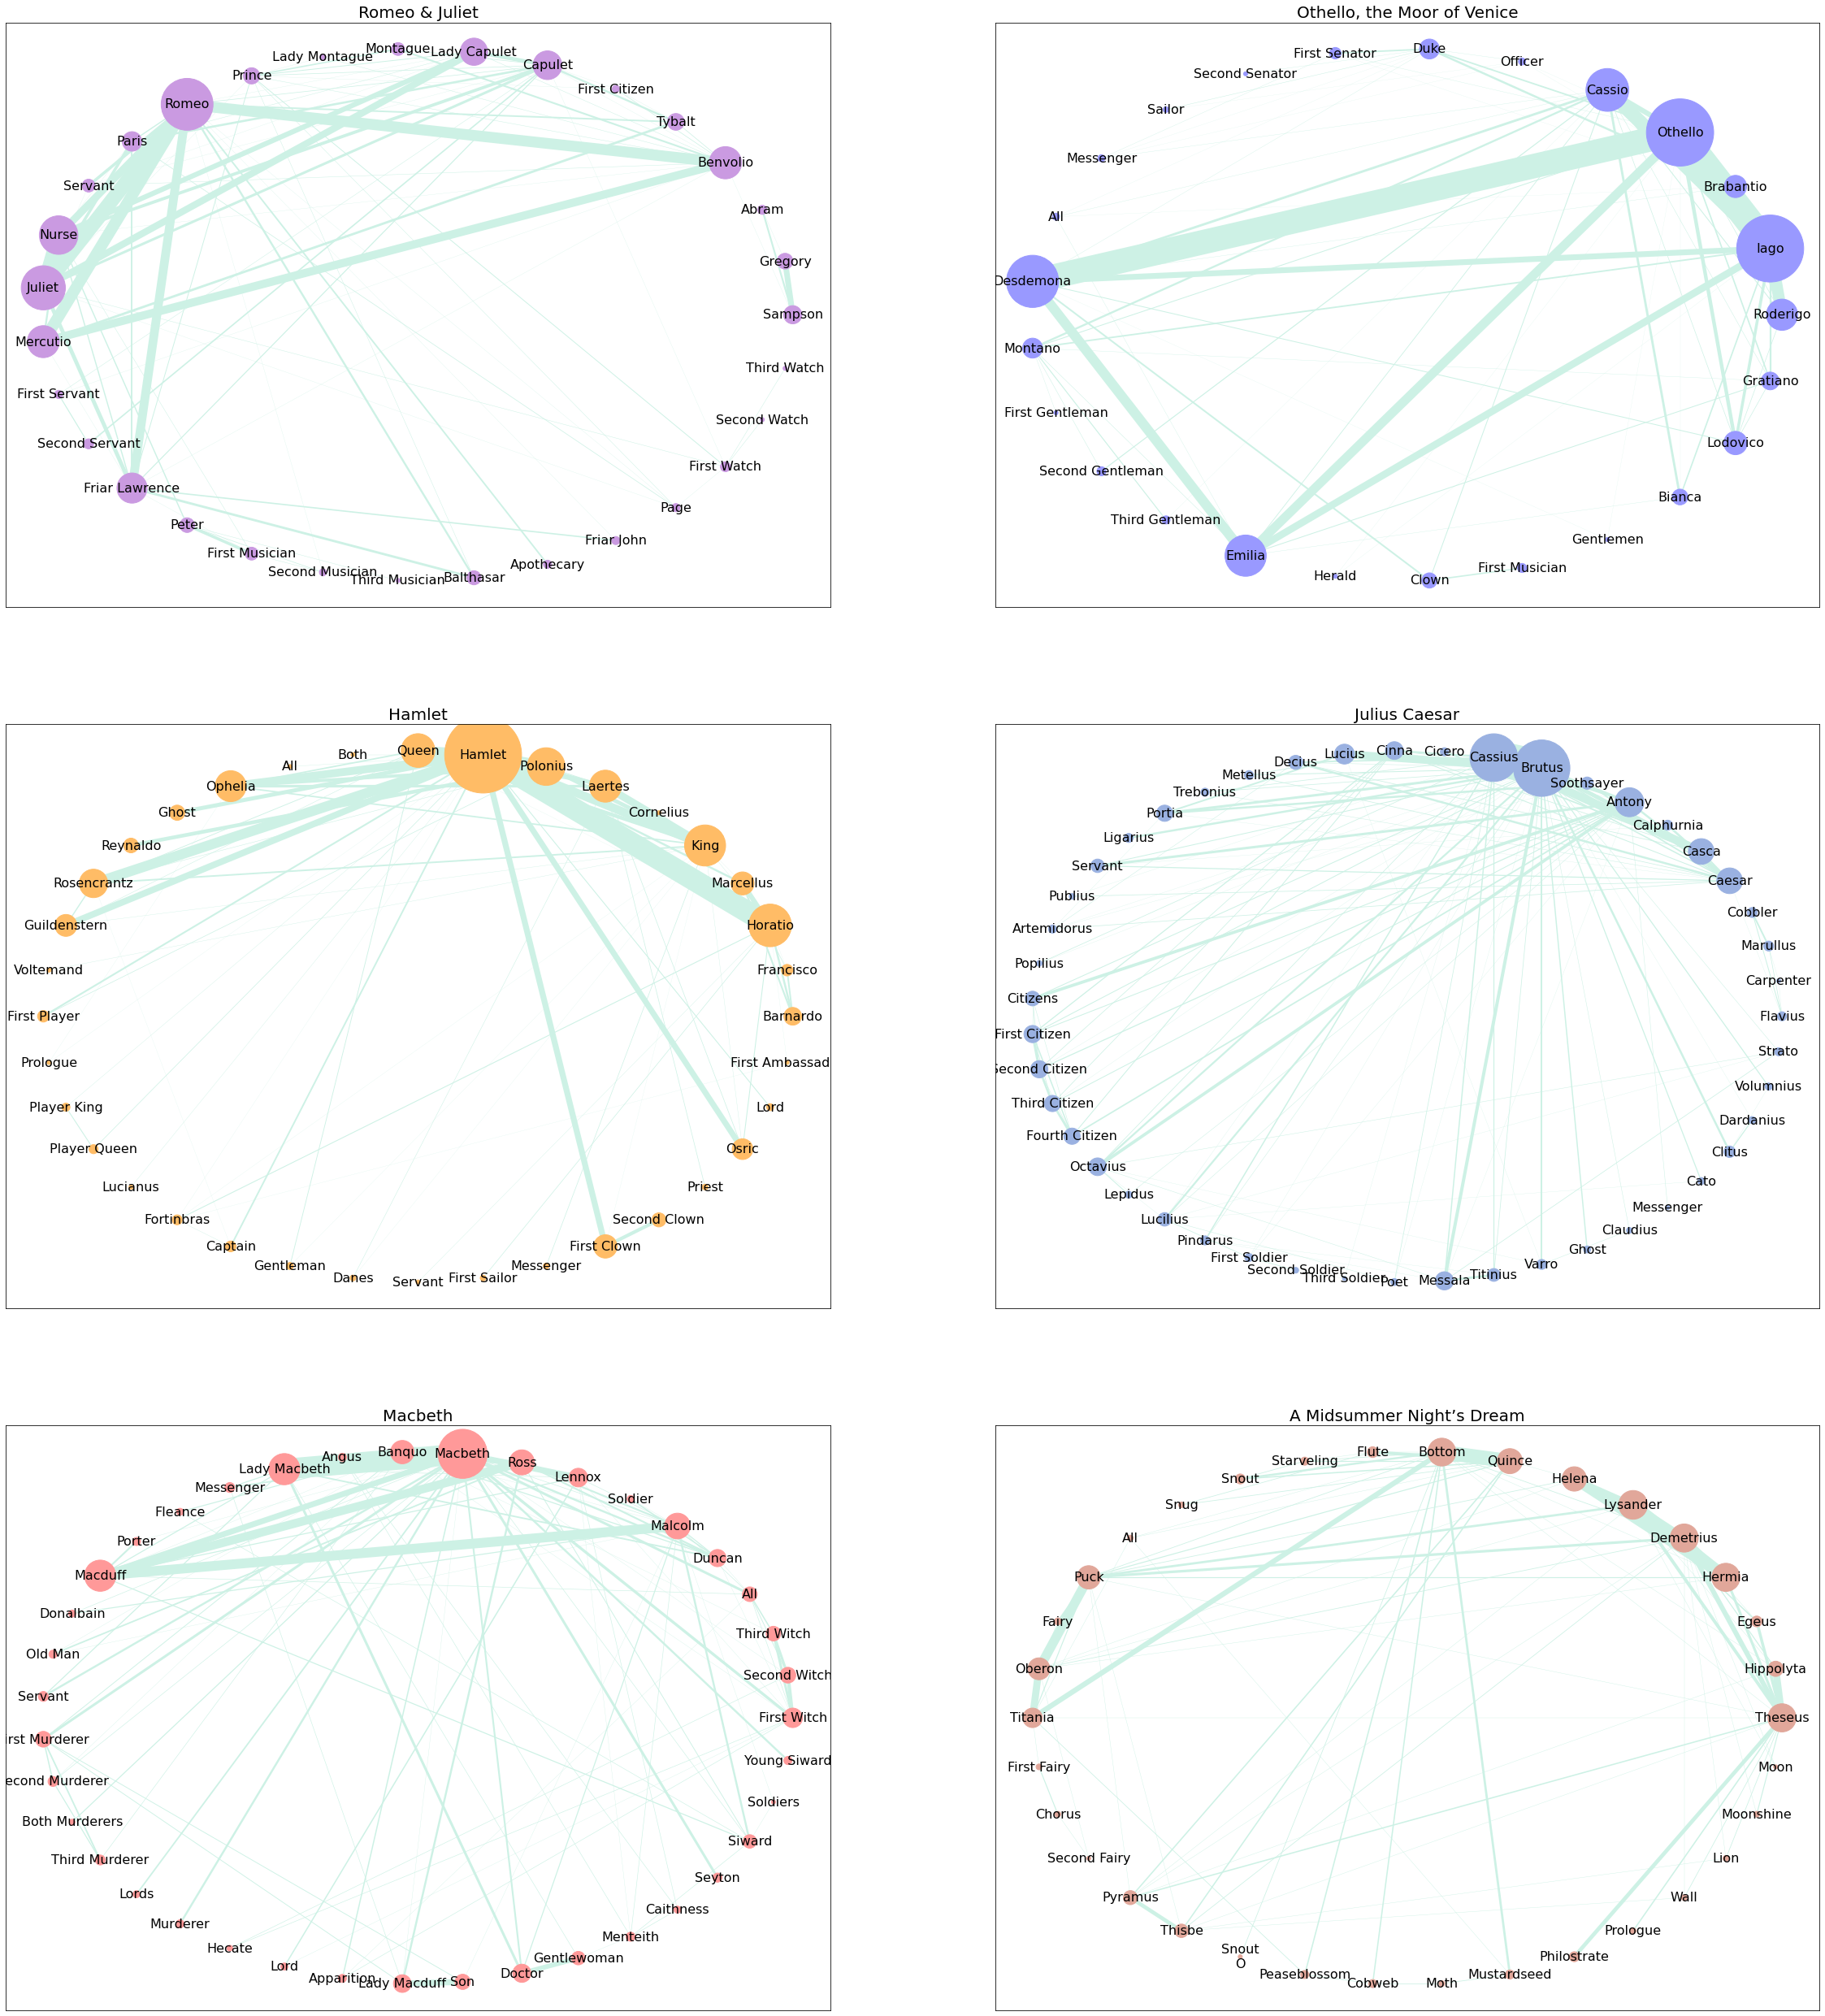

In [16]:
fig, axs = plt.subplots(nrows = 3, ncols = 2,  figsize = (40,45));

counter = 0
for row in axs:
    for subplot in row:
        all_components = [list(i) for i in sorted(nx.connected_components(all_plays[counter]), key=len, reverse=True)]
        G = nx.subgraph(all_plays[counter], all_components[0])
        node_list = [node for node in G.nodes()]
        node_size = [node[1]['presence']*25 for node in G.nodes(data=True)]
        sum_weights = sum([i[2]['weight'] for i in G.edges(data=True)])
        
        pos = nx.circular_layout(G)
        nx.draw_networkx_nodes(G, pos, ax=subplot, nodelist=node_list, node_size=node_size, node_color=G.graph['node_color'], label=True)
        nx.draw_networkx_labels(G, pos, ax=subplot, labels=dict(zip(node_list,node_list)), font_size=16, font_color='black')
        
        for edge in G.edges(data='weight'):
            this_weight = (edge[2]/sum_weights)*200 # FIND BETTER WAY TO NORMALIZE
            nx.draw_networkx_edges(G, pos, ax=subplot, edgelist=[edge], width=this_weight, edge_color='#CDF1E5') # darker edge_color='#C1EDDF'
        
        subplot.set_title(G.graph['title'], fontdict={'fontsize':20})
        counter += 1

In [55]:
# list(nx.find_cliques(all_plays[0]))

In [43]:
from networkx.algorithms.community import k_clique_communities

In [54]:
for i in all_plays:
    print(i.graph['name'],'\n',list(k_clique_communities(i, 3, nx.find_cliques(i))), '\n')

romeo 
 [frozenset({'Sampson', 'Abram', 'Gregory'}), frozenset({'Page', 'Capulet', 'Friar John', 'Second Musician', 'Montague', 'Prince', 'Servant', 'Paris', 'Friar Lawrence', 'Nurse', 'Balthasar', 'First Servant', 'First Musician', 'Mercutio', 'Lady Capulet', 'First Citizen', 'Juliet', 'Lady Montague', 'Peter', 'Tybalt', 'Romeo', 'Second Servant', 'Benvolio', 'First Watch'})] 

othello 
 [frozenset({'Messenger', 'Emilia', 'Roderigo', 'Officer', 'Montano', 'Gentlemen', 'All', 'Sailor', 'Iago', 'Brabantio', 'Clown', 'Desdemona', 'Gratiano', 'Herald', 'First Senator', 'Cassio', 'Bianca', 'Lodovico', 'Duke', 'Third Gentleman', 'Othello', 'Second Gentleman'})] 

hamlet 
 [frozenset({'Barnardo', 'Rosencrantz', 'Marcellus', 'Danes', 'Francisco', 'Queen', 'Guildenstern', 'Hamlet', 'First Player', 'Horatio', 'Gentleman', 'King', 'Prologue', 'Ophelia', 'Laertes', 'Polonius', 'Captain', 'Fortinbras', 'First Ambassador', 'First Clown', 'Osric'}), frozenset({'Hamlet', 'Player Queen', 'Player King'

# END